# この水は人間にとって安全かどうか分析

今回はロジスティック回帰を使用したモデルの作成から評価までを行う事を目的としました。

データの詳細は以下のURLより確認できます。

https://www.kaggle.com/adityakadiwal/water-potability


In [2]:
#モジュールの読み込み

import numpy as np
import pandas as pd
from scipy import stats

import statsmodels.formula.api as smf
import statsmodels.api as sm

from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn import metrics

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set()

In [24]:
#データを読み込む

data = pd.read_csv("water_potability.csv")
data.describe()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
count,2785.000000,3276.000000,3276.000000,3276.000000,2495.000000,3276.000000,3276.000000,3114.000000,3276.000000,3276.000000
mean,7.080795,196.369496,22014.092526,7.122277,333.775777,426.205111,14.284970,66.396293,3.966786,0.390110
std,1.594320,32.879761,8768.570828,1.583085,41.416840,80.824064,3.308162,16.175008,0.780382,0.487849
min,0.000000,47.432000,320.942611,0.352000,129.000000,181.483754,2.200000,0.738000,1.450000,0.000000
25%,6.093092,176.850538,15666.690297,6.127421,307.699498,365.734414,12.065801,55.844536,3.439711,0.000000
50%,7.036752,196.967627,20927.833607,7.130299,333.073546,421.884968,14.218338,66.622485,3.955028,0.000000
75%,8.062066,216.667456,27332.762127,8.114887,359.950170,481.792304,16.557652,77.337473,4.500320,1.000000
max,14.000000,323.124000,61227.196008,13.127000,481.030642,753.342620,28.300000,124.000000,6.739000,1.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd043853d90>,
      dtype=object)

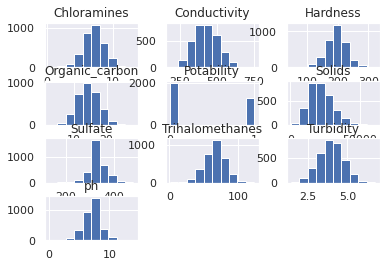

In [23]:
#各データの分布を確認
data.hist()

In [31]:
#欠損値の確認

col_names = data.columns
for col_name in col_names:
    missing_num = sum(pd.isnull(data[col_name]))
    print(col_name, ': missing record number is', missing_num)

ph : missing record number is 491
Hardness : missing record number is 0
Solids : missing record number is 0
Chloramines : missing record number is 0
Sulfate : missing record number is 781
Conductivity : missing record number is 0
Organic_carbon : missing record number is 0
Trihalomethanes : missing record number is 162
Turbidity : missing record number is 0
Potability : missing record number is 0


In [32]:
#欠損値の補充

data["ph"] = data["ph"].fillna(data["ph"].mean())

data["Sulfate"] = data["Sulfate"].fillna(data["Sulfate"].mean())

data["Trihalomethanes"] = data["Trihalomethanes"].fillna(data["Trihalomethanes"].mean())

In [33]:
#欠損値が埋まっているか確認
col_names = data.columns
for col_name in col_names:
    missing_num = sum(pd.isnull(data[col_name]))
    print(col_name, ': missing record number is', missing_num)

ph : missing record number is 0
Hardness : missing record number is 0
Solids : missing record number is 0
Chloramines : missing record number is 0
Sulfate : missing record number is 0
Conductivity : missing record number is 0
Organic_carbon : missing record number is 0
Trihalomethanes : missing record number is 0
Turbidity : missing record number is 0
Potability : missing record number is 0


In [34]:
#各相関係数を確認し相関係数0.8以上のあるか確認
threshold = 0.8
corr_matrix = data.corr().abs()
corr_matrix.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
ph,1.000000,0.075833,0.081884,0.031811,0.014403,0.017192,0.040061,0.002994,0.036222,0.003287
Hardness,0.075833,1.000000,0.046899,0.030054,0.092766,0.023915,0.003610,0.012690,0.014449,0.013837
Solids,0.081884,0.046899,1.000000,0.070148,0.149840,0.013831,0.010242,0.008875,0.019546,0.033743
Chloramines,0.031811,0.030054,0.070148,1.000000,0.023791,0.020486,0.012653,0.016627,0.002363,0.023779
Sulfate,0.014403,0.092766,0.149840,0.023791,1.000000,0.014059,0.026909,0.025605,0.009790,0.020619


In [35]:
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
upper.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
ph,NaN,0.075833,0.081884,0.031811,0.014403,0.017192,0.040061,0.002994,0.036222,0.003287
Hardness,NaN,NaN,0.046899,0.030054,0.092766,0.023915,0.003610,0.012690,0.014449,0.013837
Solids,NaN,NaN,NaN,0.070148,0.149840,0.013831,0.010242,0.008875,0.019546,0.033743
Chloramines,NaN,NaN,NaN,NaN,0.023791,0.020486,0.012653,0.016627,0.002363,0.023779
Sulfate,NaN,NaN,NaN,NaN,NaN,0.014059,0.026909,0.025605,0.009790,0.020619


In [36]:
to_drop = [column for column in upper.columns if column != "Potability" if any(upper[column] > threshold)]

print("削除する変数：", to_drop)
print("削除する変数の数：", len(to_drop))

#今回のデータでは相関係数0.8以上のものはないのでそのままにします

削除する変数： []
削除する変数の数： 0


In [63]:
#データをテストと訓練に分ける。
X = data.drop(columns=["Potability"])
y = data["Potability"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state = 17)

In [55]:
#モデル構築
model = smf.glm("Potability~ph+Hardness+Chloramines+Sulfate+Conductivity+Trihalomethanes+Organic_carbon+Turbidity", data=data, family=sm.families.Binomial()).fit()

In [56]:
#モデル評価
model.aic

4392.823063334915

In [65]:
#このモデルで分析
y_pred = model.predict(X_test)
y_pred

1471    0.372934
861     0.404369
248     0.358152
1346    0.380728
2539    0.405863
          ...   
1132    0.357812
461     0.404794
413     0.403578
1233    0.393885
1644    0.386041
Length: 656, dtype: float64

In [66]:
#0.5以上を１に0.5未満を０にするようにする
y_pred2 = np.round(y_pred.fillna(0.0)).astype(int)
y_pred2

1471    0
861     0
248     0
1346    0
2539    0
       ..
1132    0
461     0
413     0
1233    0
1644    0
Length: 656, dtype: int64

In [59]:
#モデルの予測結果を表示
print(metrics.classification_report(y_test, y_pred2))

              precision    recall  f1-score   support

           0       0.62      1.00      0.77       610
           1       0.00      0.00      0.00       373

    accuracy                           0.62       983
   macro avg       0.31      0.50      0.38       983
weighted avg       0.39      0.62      0.48       983



以上の結果より今回私が作成したモデルでは正解率は約50%でした。

分類としては良くない結果に終わってしまいましたが今後改善していく予定です。